# Time Series Analysis and Forecasting for JJ dataset
# LSTM and GRU Models

Dataset contains 84 quarterly records from 1960 to 1980


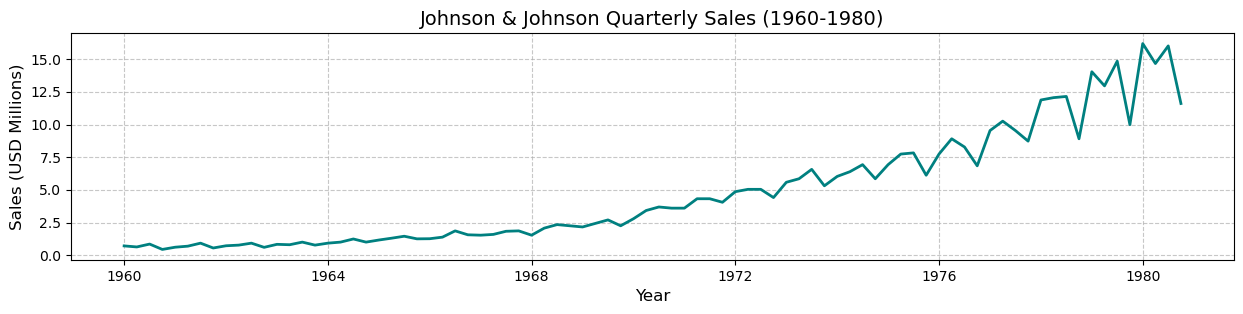

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Load and prepare data
df = pd.read_csv('jj.csv', parse_dates=['date'])
print(f"Dataset contains {len(df)} quarterly records from {df['date'].min().year} to {df['date'].max().year}")

plt.figure(figsize=(15, 10))
# Raw data plot
plt.subplot(3, 1, 1)
plt.plot(df['date'], df['data'], color='teal', linewidth=2)
plt.title('Johnson & Johnson Quarterly Sales (1960-1980)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales (USD Millions)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


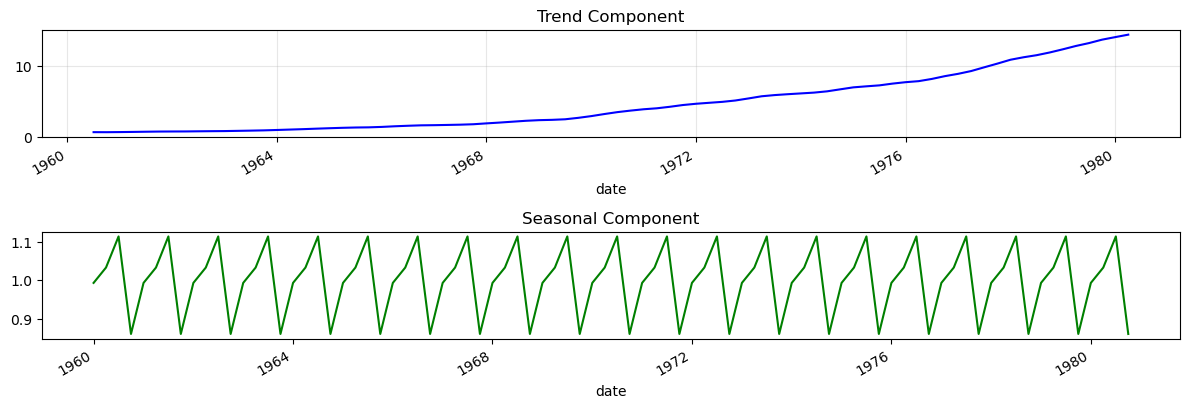

In [10]:
# Seasonal decomposition
result = seasonal_decompose(df.set_index('date')['data'], model='multiplicative', period=4)
plt.subplot(3, 1, 2)
result.trend.plot(color='blue', title='Trend Component')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
result.seasonal.plot(color='green', title='Seasonal Component')
plt.tight_layout()
plt.savefig('jj_decomposition.png', dpi=300)
plt.show()

In [11]:
# Train-test split (last 8 quarters for testing)
train = df.iloc[:-8]
test = df.iloc[-8:]
print(f"\nTrain period: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"Test period: {test['date'].min().date()} to {test['date'].max().date()}")

# Transformations
train_log = np.log(train['data'])
test_log = np.log(test['data'])

# Differencing with seasonal adjustment (annual differencing)
train_log_diff = train_log.diff(4).dropna()



Train period: 1960-01-01 to 1978-10-01
Test period: 1979-01-01 to 1980-10-01



Stationarity check (log + seasonal diff):


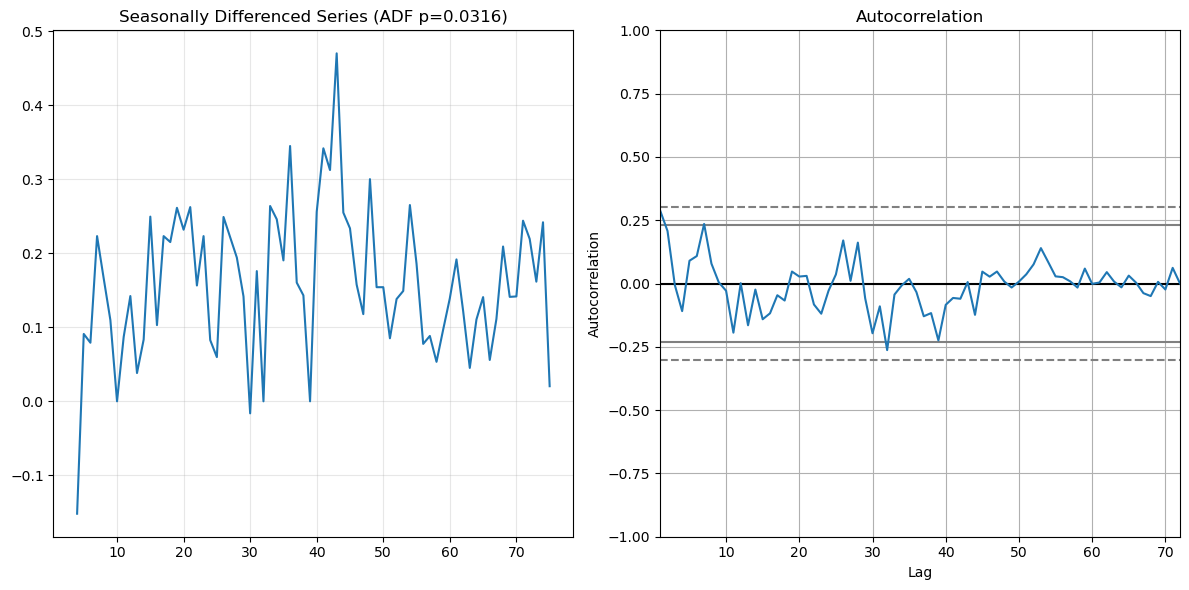

In [12]:
# Stationarity Check 
def enhanced_stationarity_check(series, title):
    plt.figure(figsize=(12, 6))
    
    # ADF test
    result = adfuller(series)
    is_stationary = result[1] < 0.05
    
    # Plotting
    plt.subplot(1, 2, 1)
    plt.plot(series)
    plt.title(f'{title} (ADF p={result[1]:.4f})')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    pd.plotting.autocorrelation_plot(series)
    plt.title('Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    return is_stationary

print("\nStationarity check (log + seasonal diff):")
stationary = enhanced_stationarity_check(train_log_diff, 'Seasonally Differenced Series')


In [13]:
# Prepare training sequences
n_steps = 8  # Increased window size to capture longer patterns
X_train, y_train = [], []

for i in range(n_steps, len(train_log_diff)):
    X_train.append(train_log_diff[i-n_steps:i].values)
    y_train.append(train_log_diff[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Create separate scalers for features and target
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

# Reshape for LSTM/GRU [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], n_steps, 1))


LSTM and GRU Model Optimization

In [14]:
# --- Optimized Model Architecture ---
def create_model(model_type='lstm'):
    model = Sequential()
    
    if model_type == 'lstm':
        model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, 1)))
        model.add(Dropout(0.4))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.3))
    else:
        model.add(GRU(128, return_sequences=True, input_shape=(n_steps, 1)))
        model.add(Dropout(0.4))
        model.add(GRU(64, return_sequences=False))
        model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mse',
                  metrics=['mae'])
    return model

lstm_model = create_model('lstm')
gru_model = create_model('gru')

print("\nLSTM Model Summary:")
lstm_model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train models
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=16,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining GRU model...")
gru_history = gru_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,
    batch_size=16,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1
)



LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 8, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,241 (477.50 KB)

 Trainable params: 122,241 (477.50 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.9883 - mae: 0.7886 - val_loss: 0.5053 - val_mae: 0.6180
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9435 - mae: 0.7749 - val_loss: 0.4841 - val_mae: 0.6039
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8889 - mae: 0.7535 - val_loss: 0.4614 - val_mae: 0.5880
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8732 - mae: 0.7506 - val_loss: 0.4354 - val_mae: 0.5686
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8295 - mae: 0.7377 - val_loss: 0.4062 - val_mae: 0.5454
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7996 - mae: 0.7211 - val_loss: 0.3764 - val_mae: 0.5201
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7794 - mae: 0.7097 - val_loss: 0.3483 - val_mae: 0.4940
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7856 - mae: 0.7158 - val_loss: 0.3237 - val_mae: 0.4689
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/st

In [19]:
# --- Advanced Forecasting Function ---
def enhanced_forecast(model, initial_sequence, X_scaler, y_scaler, steps, last_log_series):
    history = list(initial_sequence)
    predictions = []
    
    for _ in range(steps):
        # Prepare input - use X_scaler for features
        X_input = X_scaler.transform(np.array(history[-n_steps:]).reshape(1, -1))
        X_input = X_input.reshape((1, n_steps, 1))
        
        # Predict next difference
        pred_diff_scaled = model.predict(X_input, verbose=0)[0][0]
        # Use y_scaler for target inverse transform
        pred_diff = y_scaler.inverse_transform([[pred_diff_scaled]])[0][0]
        
        # Store prediction
        predictions.append(pred_diff)
        history.append(pred_diff)
    
    # Convert seasonal differences to absolute values
    seasonal_base = last_log_series[-4:].values  # Last year of provided log values
    abs_predictions = []
    
    for i, diff in enumerate(predictions):
        if i < 4:
            # First year: use training data as base
            base = seasonal_base[i]
        else:
            # Subsequent years: use predictions as base
            base = abs_predictions[i-4]
        abs_value = base + diff
        abs_predictions.append(abs_value)
    
    return np.exp(abs_predictions)

# Prepare initial sequence
initial_seq = train_log_diff[-n_steps:].values

# Generate forecasts
lstm_predictions = enhanced_forecast(lstm_model, initial_seq, X_scaler, y_scaler, len(test), train_log)
gru_predictions = enhanced_forecast(gru_model, initial_seq, X_scaler, y_scaler, len(test), train_log)


In [20]:
# --- Comprehensive Evaluation ---
results = test.copy()
results['LSTM'] = lstm_predictions
results['GRU'] = gru_predictions

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(results['data'], results['LSTM'])
gru_mae, gru_rmse, gru_mape = calculate_metrics(results['data'], results['GRU'])

print("\nModel Performance Evaluation:")
print(f"{'Metric':<10} {'LSTM':<10} {'GRU':<10}")
print(f"{'MAE':<10} {lstm_mae:.4f}    {gru_mae:.4f}")
print(f"{'RMSE':<10} {lstm_rmse:.4f}    {gru_rmse:.4f}")
print(f"{'MAPE':<10} {lstm_mape:.2f}%     {gru_mape:.2f}%")



Model Performance Evaluation:
Metric     LSTM       GRU       
MAE        0.5657    0.6730
RMSE       0.7942    0.8615
MAPE       4.12%     4.90%


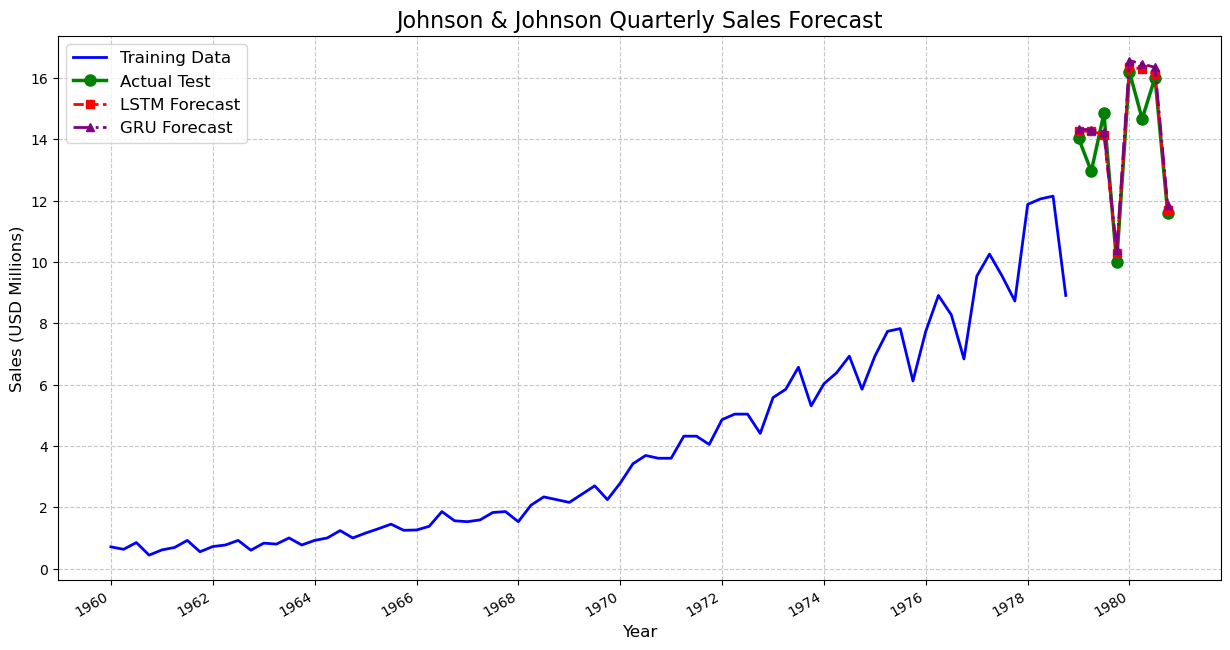

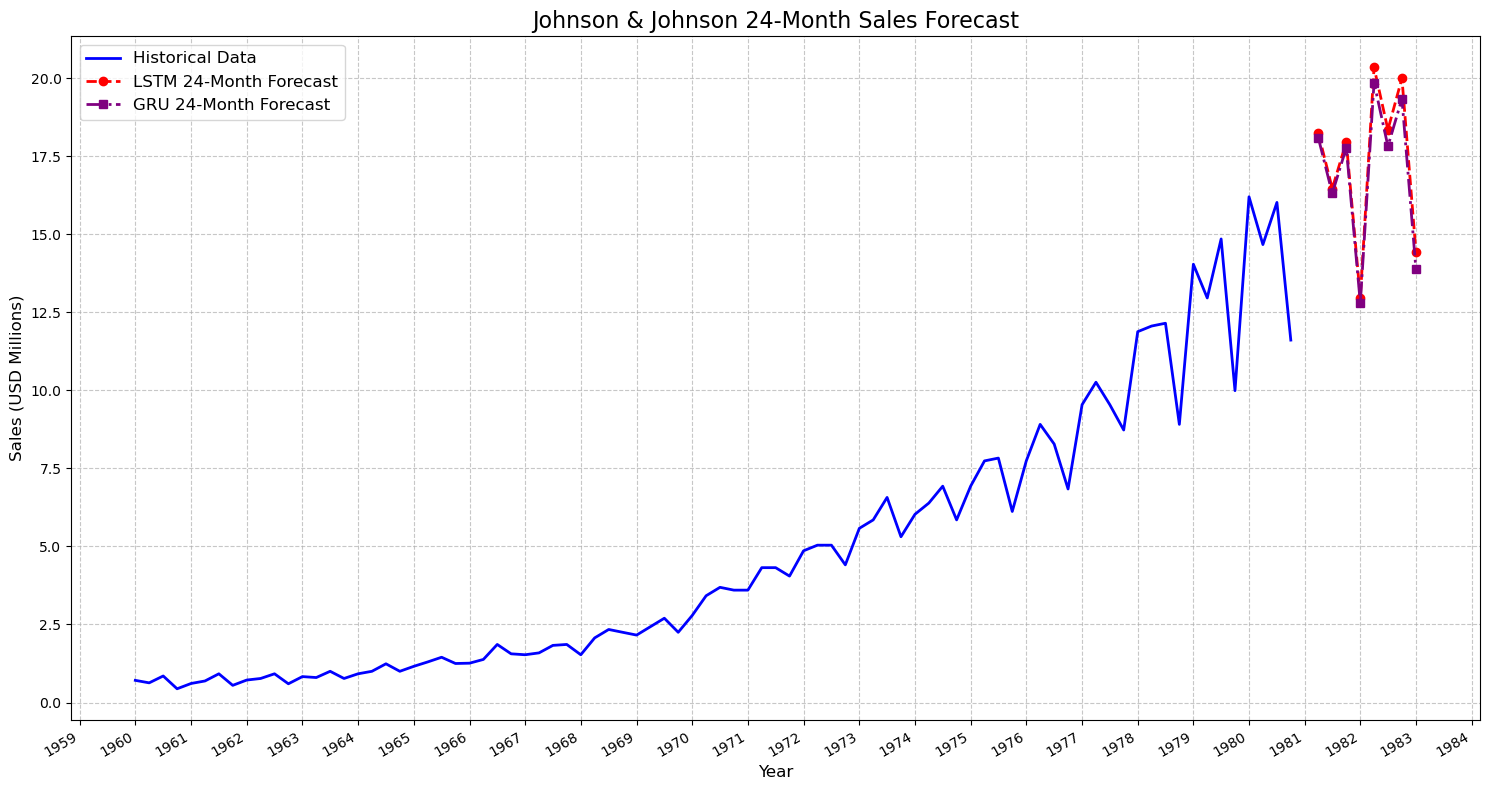


24-Month Forecast:
        Date  LSTM_Forecast  GRU_Forecast
0 1981-03-31          18.23         18.08
1 1981-06-30          16.47         16.31
2 1981-09-30          17.96         17.77
3 1981-12-31          12.97         12.80
4 1982-03-31          20.35         19.86
5 1982-06-30          18.35         17.82
6 1982-09-30          20.00         19.34
7 1982-12-31          14.43         13.87


In [21]:
# --- Visualizations ---
plt.figure(figsize=(15, 8))

# Training data
plt.plot(train['date'], train['data'], label='Training Data', color='blue', linewidth=2)

# Test data
plt.plot(test['date'], test['data'], label='Actual Test', color='green', 
         linewidth=2.5, marker='o', markersize=8)

# Forecasts
plt.plot(results['date'], results['LSTM'], label='LSTM Forecast', 
         color='red', linestyle='--', linewidth=2, marker='s', markersize=6)
plt.plot(results['date'], results['GRU'], label='GRU Forecast', 
         color='purple', linestyle='-.', linewidth=2, marker='^', markersize=6)

# Formatting
plt.title('Johnson & Johnson Quarterly Sales Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales (USD Millions)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()


# --- 24-Month Future Forecast ---
# Prepare final sequence using all available data
full_log = np.log(df['data'])
full_log_diff = full_log.diff(4).dropna()
final_seq = full_log_diff[-n_steps:].values

# Generate forecast
future_steps = 8  # 8 quarters = 24 months
lstm_future = enhanced_forecast(lstm_model, final_seq, X_scaler, y_scaler, future_steps, full_log)
gru_future = enhanced_forecast(gru_model, final_seq, X_scaler, y_scaler, future_steps, full_log)

# Create future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=3),
    periods=future_steps,
    freq='Q'
)

# Plot future forecast
plt.figure(figsize=(15, 8))
plt.plot(df['date'], df['data'], label='Historical Data', color='blue', linewidth=2)
plt.plot(future_dates, lstm_future, label='LSTM 24-Month Forecast', 
         color='red', linestyle='--', linewidth=2, marker='o')
plt.plot(future_dates, gru_future, label='GRU 24-Month Forecast', 
         color='purple', linestyle='-.', linewidth=2, marker='s')

plt.title('Johnson & Johnson 24-Month Sales Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales (USD Millions)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Print future forecasts
future_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Forecast': lstm_future,
    'GRU_Forecast': gru_future
})
print("\n24-Month Forecast:")
print(future_df.round(2))

# Time Series Analysis and Forecasting for JJ dataset
# ARIMA Model 

In [41]:
# Import Libraries and Load the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv("jj.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df.rename(columns={"data": "Sales"}, inplace=True)
print(df.head())

            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61


In [42]:
# Check for Stationarity (ADF Test)
result = adfuller(df['Sales'])
print(f"\nADF Statistic (Original): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")


ADF Statistic (Original): 2.742
p-value: 1.0000


In [44]:
# Here, Data is non-stationary (p>0.05), This means we fail to reject the null hypothesis of a unit root.
# i.e,the time series is non-stationary 
# Log transform the sales
log_sales = np.log(df['Sales'])

# Difference the log-transformed series
log_diff1 = log_sales.diff().dropna()

# ADF test on the differenced log series
result = adfuller(log_diff1)
print(f"\nADF Statistic (Log-Differenced): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")


ADF Statistic (Log-Differenced): -4.317
p-value: 0.0004


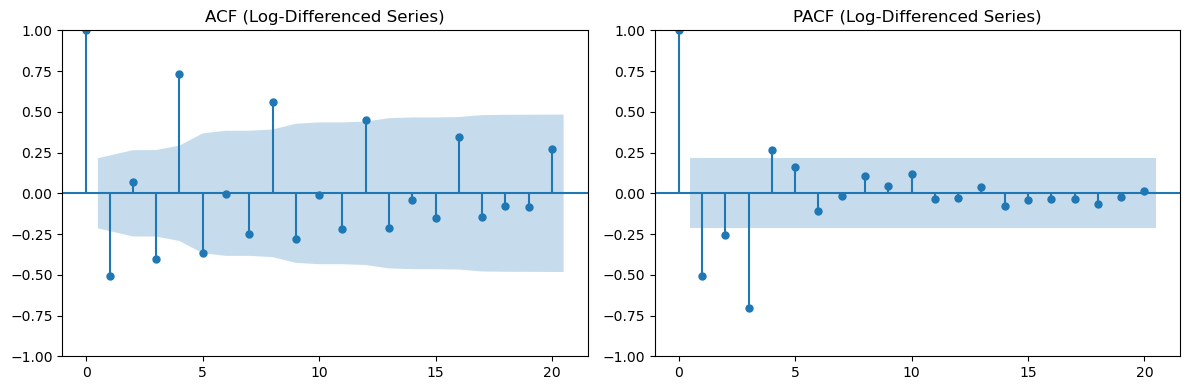

In [46]:
# Now stationary(p<0.05)
# Plot ACF and PACF for the Stationary Series

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(log_diff1, lags=20, ax=plt.gca())
plt.title("ACF (Log-Differenced Series)")

plt.subplot(1, 2, 2)
plot_pacf(log_diff1, lags=20, ax=plt.gca(), method="ywm")
plt.title("PACF (Log-Differenced Series)")
plt.tight_layout()
plt.show()

In [47]:
#ARIMA Modeling

# Define your time series data
data = log_sales  # Ensure this is a pandas Series with datetime index

# Define the range for p, d, q
p_range = 5
d_range = 2
q_range = 5

# Initialize best values
best_aic = float('inf')
best_order = None
best_model = None

# Loop over all combinations of p, d, q
for p in range(p_range):
    for d in range(d_range):
        for q in range(q_range):
            try:
                model = sm.tsa.arima.ARIMA(data, order=(p, d, q))
                results = model.fit()
                print(f"Fitted ARIMA({p},{d},{q}) - AIC: {results.aic:.2f}")

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except Exception as e:
                print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")

# Output best model
print(f"\nBest ARIMA order by AIC: {best_order}, AIC = {best_aic:.3f}")


Fitted ARIMA(0,0,0) - AIC: 246.23
Fitted ARIMA(0,0,1) - AIC: 170.37
Fitted ARIMA(0,0,2) - AIC: 81.64
Fitted ARIMA(0,0,3) - AIC: 58.78
Fitted ARIMA(0,0,4) - AIC: 40.04
Fitted ARIMA(0,1,0) - AIC: -20.23
Fitted ARIMA(0,1,1) - AIC: -42.27
Fitted ARIMA(0,1,2) - AIC: -49.14
Fitted ARIMA(0,1,3) - AIC: -56.87
Fitted ARIMA(0,1,4) - AIC: -90.24
Fitted ARIMA(1,0,0) - AIC: -13.51
Fitted ARIMA(1,0,1) - AIC: -34.77
Fitted ARIMA(1,0,2) - AIC: -41.60
Fitted ARIMA(1,0,3) - AIC: -49.37
Fitted ARIMA(1,0,4) - AIC: -82.46
Fitted ARIMA(1,1,0) - AIC: -38.89
Fitted ARIMA(1,1,1) - AIC: -41.92
Fitted ARIMA(1,1,2) - AIC: -53.08
Fitted ARIMA(1,1,3) - AIC: -70.91
Fitted ARIMA(1,1,4) - AIC: -93.30
Fitted ARIMA(2,0,0) - AIC: -31.53
Fitted ARIMA(2,0,1) - AIC: -34.41
Fitted ARIMA(2,0,2) - AIC: -45.55
Fitted ARIMA(2,0,3) - AIC: -55.24
Fitted ARIMA(2,0,4) - AIC: -85.68
Fitted ARIMA(2,1,0) - AIC: -39.05
Fitted ARIMA(2,1,1) - AIC: -40.35
Fitted ARIMA(2,1,2) - AIC: -52.21
Fitted ARIMA(2,1,3) - AIC: -59.73
Fitted ARIMA(2,1,

In [48]:
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Mon, 16 Jun 2025   AIC                           -144.198
Time:                        10:20:09   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

In [49]:
# Forecast 8 steps ahead (8 quarters = 24 months)
n_steps = 8
forecast_result = model_fit.get_forecast(steps=n_steps)
# Predicted mean in log scale and its conf. interval
log_forecast = forecast_result.predicted_mean
log_conf_int = forecast_result.conf_int()

# Convert forecasts back to original scale
forecast = np.exp(log_forecast)
conf_int_lower = np.exp(log_conf_int['lower Sales'])
conf_int_upper = np.exp(log_conf_int['upper Sales'])

# Display the forecast values and confidence intervals
forecast.index = pd.date_range(start='1981-01-01', periods=n_steps, freq='Q')
print(forecast)
print(conf_int_lower)
print(conf_int_upper)



1981-03-31    18.040641
1981-06-30    16.652442
1981-09-30    18.003913
1981-12-31    13.452457
1982-03-31    20.327859
1982-06-30    18.816207
1982-09-30    20.201683
1982-12-31    15.522581
Freq: Q-DEC, Name: predicted_mean, dtype: float64
84    15.183629
85    13.882934
86    14.763898
87    11.005079
88    15.417940
89    14.100820
90    14.869924
91    11.357666
Name: lower Sales, dtype: float64
84    21.435241
85    19.974439
86    21.954965
87    16.444097
88    26.801366
89    25.108444
90    27.445196
91    21.214790
Name: upper Sales, dtype: float64


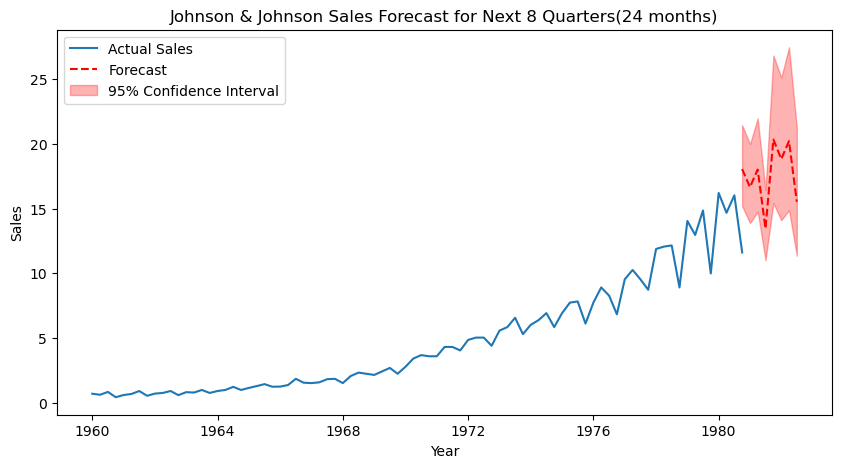

In [50]:
# Plot the Forecast vs Original Series

# Prepare index for forecast periods
forecast_index = pd.date_range(start='1980-08-01', periods=8, freq='Q')
# Plot the original series and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, df['Sales'], label='Actual Sales')
plt.plot(forecast_index, forecast.values, label='Forecast', color='red', linestyle='--')
# Plot confidence interval as shaded area
plt.fill_between(forecast_index, conf_int_lower.values, conf_int_upper.values, 
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()


In [53]:
# Compute In-Sample Metrics
in_sample_predictions = model_fit.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_log = in_sample_predictions.predicted_mean
predicted_sales = np.exp(predicted_log)

# Actual values (original scale)
actual_sales = df.loc[predicted_log.index, "Sales"]

# Calculate metrics
mae = mean_absolute_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100

print("\nIn-Sample Evaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


In-Sample Evaluation Metrics:
MAE  : 0.28
RMSE : 0.40
MAPE : 8.21%


# Time Series Analysis and Forecasting for Amazon dataset
# ARIMA, LSTM, and GRU

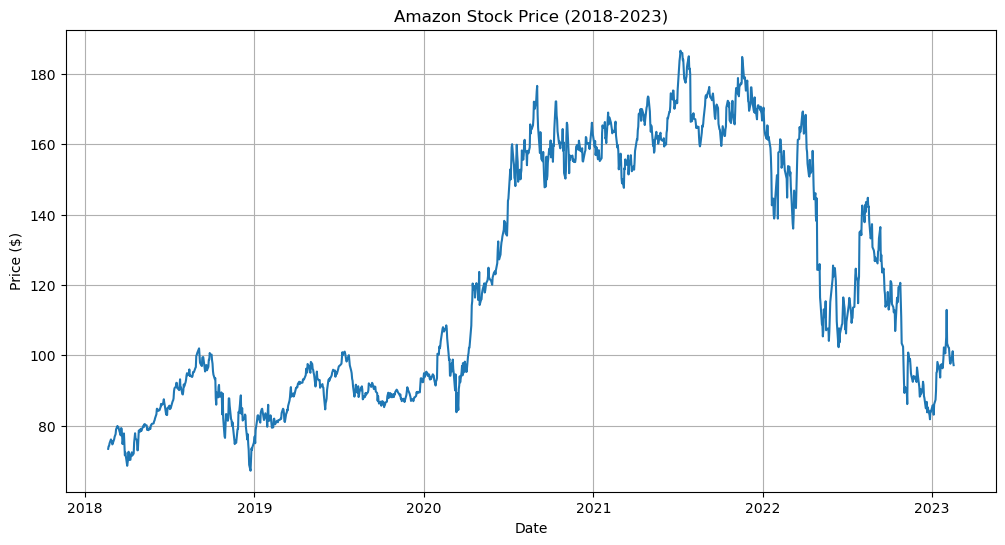

In [1]:
# Import Librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 6]

# Load data
amzn_df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
amzn_df = amzn_df[['Close']].rename(columns={'Close': 'Price'})

# Visualize
plt.plot(amzn_df['Price'])
plt.title('Amazon Stock Price (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

In [2]:
# Stationarity Analysis for amima modeling
# ADF Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')

print("Original Data:")
adf_test(amzn_df['Price'])

# Transform to stationary series
amzn_df['Log_Price'] = np.log(amzn_df['Price'])
amzn_df['Diff_Log_Price'] = amzn_df['Log_Price'].diff().dropna()

print("\nDifferenced Log Data:")
adf_test(amzn_df['Diff_Log_Price'].dropna())

Original Data:
ADF Statistic: -1.6578
p-value: 0.4530
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680

Differenced Log Data:
ADF Statistic: -36.6398
p-value: 0.0000
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680


ARIMA Modeling

In [3]:
# Auto ARIMA for parameter selection
auto_model = auto_arima(
    amzn_df['Log_Price'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
best_order = auto_model.order

# Fit ARIMA model with proper configuration
model_arima = SARIMAX(
    amzn_df['Log_Price'],  # Use the log-transformed series
    order=best_order,
    simple_differencing=False  # This is crucial for proper naming
)
result_arima = model_arima.fit(disp=False)

# Forecast next 24 months (≈504 trading days)
forecast_steps = 504
forecast_log = result_arima.get_forecast(steps=forecast_steps)
forecast_mean = forecast_log.predicted_mean
conf_int = forecast_log.conf_int()

# Access confidence intervals by position instead of by name
conf_int_lower = np.exp(conf_int.iloc[:, 0])  # First column is always lower bound
conf_int_upper = np.exp(conf_int.iloc[:, 1])  # Second column is always upper bound

# Create future dates index
last_date = amzn_df.index[-1]
forecast_index = pd.bdate_range(
    start=last_date + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='B'  # Business days only
)

# Inverse transformation for the point forecast
forecast_price = np.exp(forecast_mean)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5933.337, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5938.461, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5937.887, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5937.794, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5940.340, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5934.568, Time=1.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.325 seconds


LSTM Modeling

In [4]:
# Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(amzn_df[['Price']])

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(100),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Forecasting function
def forecast_lstm(model, last_sequence, steps):
    forecasts = []
    current_seq = last_sequence.copy()
    
    for _ in range(steps):
        pred = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        forecasts.append(pred)
        current_seq = np.append(current_seq[1:], [[pred]], axis=0)
    
    return np.array(forecasts).reshape(-1, 1)

# Generate forecast
last_seq = scaled_data[-seq_length:]
lstm_forecast_scaled = forecast_lstm(model_lstm, last_seq, forecast_steps)
lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

GRU Modeling

In [5]:
# Build GRU model
model_gru = Sequential([
    GRU(100, return_sequences=True, input_shape=(seq_length, 1)),
    GRU(100),
    Dense(1)
])
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Generate forecast
gru_forecast_scaled = forecast_lstm(model_gru, last_seq, forecast_steps)
gru_forecast = scaler.inverse_transform(gru_forecast_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

Results Visualization

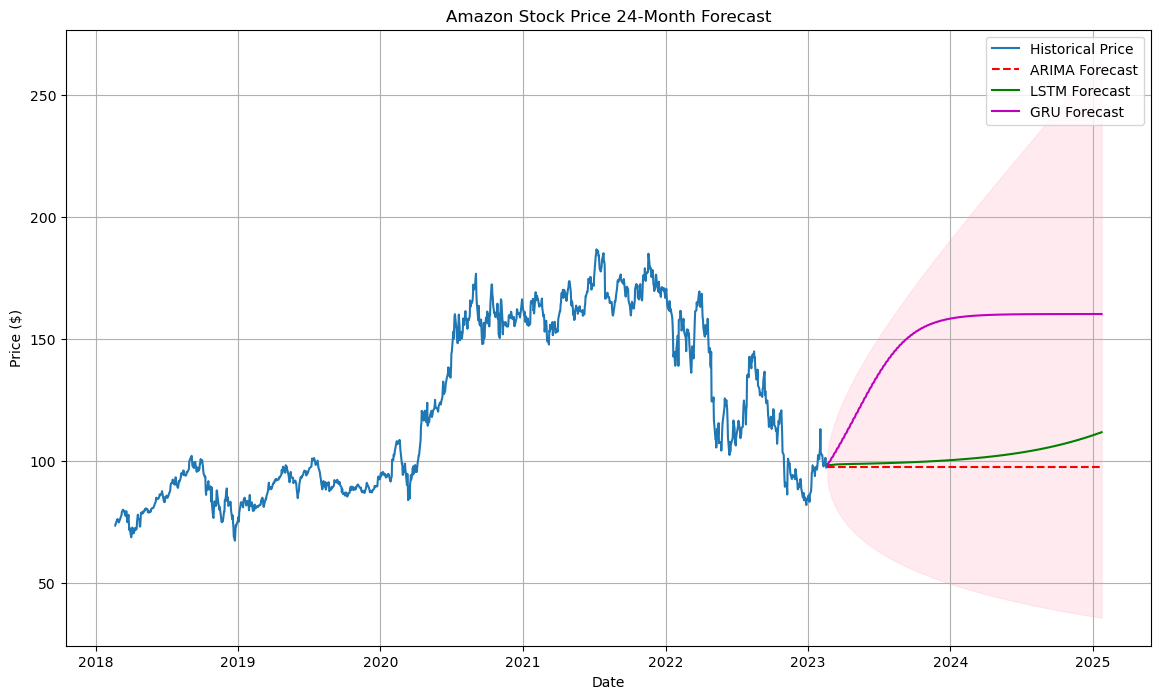

In [6]:

# Plot all forecasts
plt.figure(figsize=(14, 8))
plt.plot(amzn_df['Price'], label='Historical Price')

# ARIMA forecast
plt.plot(forecast_index, forecast_price, 'r--', label='ARIMA Forecast')
plt.fill_between(forecast_index, conf_int_lower, conf_int_upper, color='pink', alpha=0.3)

# LSTM forecast
plt.plot(forecast_index, lstm_forecast, 'g-', label='LSTM Forecast')

# GRU forecast
plt.plot(forecast_index, gru_forecast, 'm-', label='GRU Forecast')

plt.title('Amazon Stock Price 24-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Model Evaluation

In [7]:
# Create evaluation metrics function
def evaluate_model(name, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': f"{mape:.2f}%"
    }

# Prepare test data for evaluation
test_dates = amzn_df.index[split+seq_length:]
test_actual = amzn_df['Price'][split+seq_length:]

# Evaluate ARIMA
arima_pred = np.exp(result_arima.predict(start=test_dates[0], end=test_dates[-1]))
arima_metrics = evaluate_model('ARIMA', test_actual, arima_pred)

# Evaluate LSTM
lstm_pred = scaler.inverse_transform(model_lstm.predict(X_test).reshape(-1, 1))
lstm_metrics = evaluate_model('LSTM', test_actual, lstm_pred.flatten())

# Evaluate GRU
gru_pred = scaler.inverse_transform(model_gru.predict(X_test).reshape(-1, 1))
gru_metrics = evaluate_model('GRU', test_actual, gru_pred.flatten())

# Display results
results_df = pd.DataFrame([arima_metrics, lstm_metrics, gru_metrics])
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model Performance Comparison:
Model     RMSE      MAE  MAPE
ARIMA 3.681548 2.755512 2.37%
 LSTM 4.558047 3.594489 3.13%
  GRU 3.795370 2.893917 2.51%
